In [7]:
%matplotlib notebook
import datetime
import obspy

import matplotlib
import numpy 
import warnings
warnings.filterwarnings('ignore')

from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371000 # Radius of earth in meters. Use 3956 for miles
    return c * r 

from obspy.clients.fdsn import Client
client_eew = Client('http://localhost:18080')
client_eq = Client('http://165.98.224.52:8081')
client = Client('USGS')

N=7
minM = 4.9
lon=[-95,-80]
lat=[10,15]
net='NU'
end = (datetime.datetime.now()).isoformat()
start = (datetime.datetime.now()-datetime.timedelta(days=N)).isoformat()

# ssh -N -L 18080:localhost:8080  sysop@165.98.224.44

# Review of the earthquake early warning system for the N days. 

In [2]:
print('N: %s' % str(N))
print('into area %s°N %s°E' % (str(lat), str(lon)))
print("from %s" % start )
print("  to %s" % end )
print('for network %s.' % net)

N: 7
into area [10, 15]°N [-95, -80]°E
from 2017-02-17T17:41:41.669469
  to 2017-02-24T17:41:41.669390
for network NU.


## INETER observations
### Available network

<IPython.core.display.Javascript object>


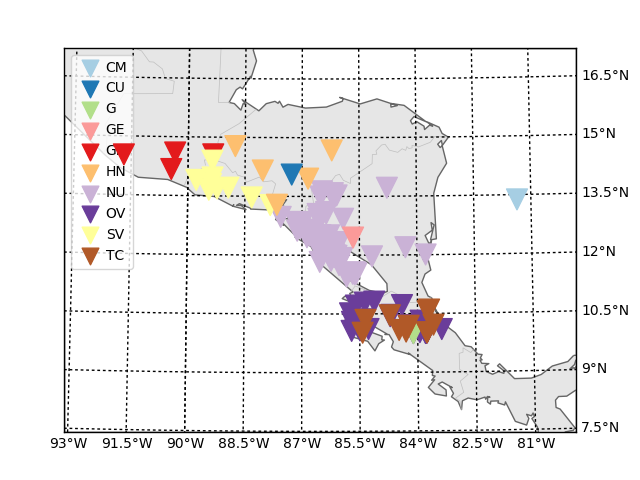

In [142]:
inv = client_eq.get_stations(starttime=start,endtime=end,minlatitude=lat[0],
                             maxlatitude=lat[1],minlongitude=lon[0],maxlongitude=lon[1],
                             level='station')
fig = inv.plot(projection='local',color_per_network=True)

###  Network that actually worked
To do

### Observed earthquakes
In main earthquake automatic location system, say **EAL**.

<IPython.core.display.Javascript object>


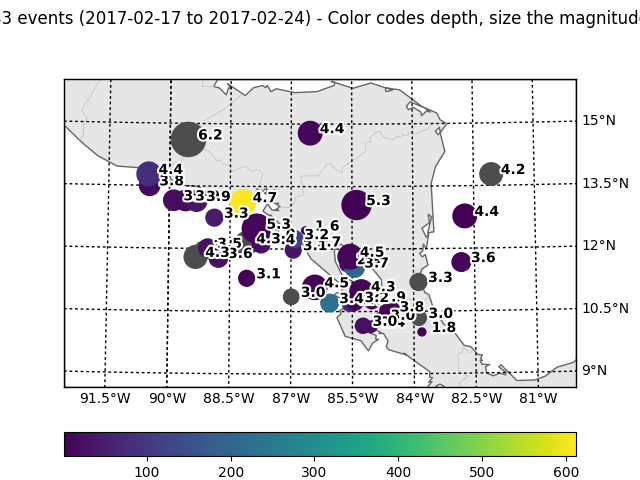

43 Event(s) in Catalog:
2017-02-23T11:27:27.298881Z | +12.447,  -86.651 | 1.638089285 M  | manual
2017-02-23T06:56:31.334140Z | +12.063,  -86.607 | 1.681117139 M  | manual
...
2017-02-24T13:41:11.509563Z | +12.487,  -87.841 | 5.328495115 M  | manual
2017-02-21T07:15:14.338108Z | +14.613,  -89.548 | 6.184471105 M  | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [12]:
cat = client_eq.get_events(starttime=start,endtime=end,#  
                           minlatitude=lat[0],maxlatitude=lat[1],minlongitude=lon[0],maxlongitude=lon[1],
                           orderby='magnitude-asc')
fig = cat.plot(projection='local')
print(cat)

### The most important earthquakes

<IPython.core.display.Javascript object>


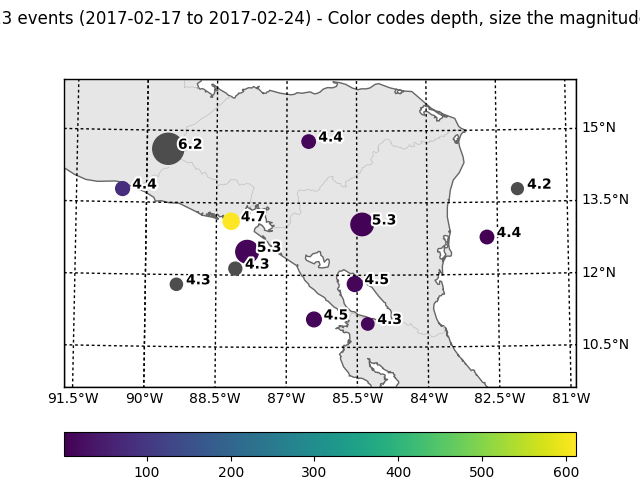

13 Event(s) in Catalog:
2017-02-19T09:52:56.314997Z | +13.770,  -82.060 | 4.228595021 M  | manual
2017-02-18T16:08:24.447767Z | +11.797,  -89.339 | 4.266935102 M  | manual
...
2017-02-24T13:41:11.509563Z | +12.487,  -87.841 | 5.328495115 M  | manual
2017-02-21T07:15:14.338108Z | +14.613,  -89.548 | 6.184471105 M  | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [13]:
subcat = cat.filter("magnitude >= 4.0")
fig = subcat.plot(projection='local',resolution='i')
print(subcat)

## Global observations

<IPython.core.display.Javascript object>


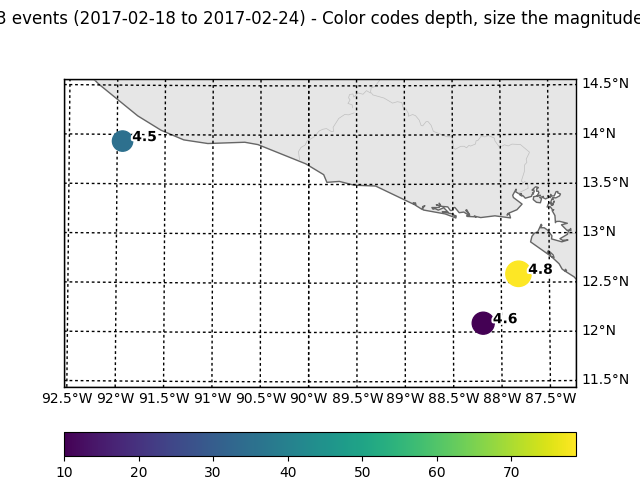

3 Event(s) in Catalog:
2017-02-18T23:31:19.130000Z | +13.933,  -91.944 | 4.5 mb
2017-02-23T15:16:11.570000Z | +12.089,  -88.191 | 4.6 mb
2017-02-24T13:41:14.960000Z | +12.587,  -87.821 | 4.8 mb


In [14]:
client = Client('IRIS')
cat_glob = client.get_events(starttime=start,endtime=end,
                                minlatitude=lat[0]-1,maxlatitude=lat[1]+1,minlongitude=lon[0]-1,maxlongitude=lon[1]+1,
                                orderby='magnitude-asc')
fig = cat_glob.plot(projection='local',resolution='i')
print(cat_glob)

### Is something missing in EAL?

In [15]:
for e in cat_glob.events:
    o = e.preferred_origin() or e.origins[-1]
    found=False     
    print('---- glob',e.short_str(),'...')
    for ref in cat.events: 
        refo = ref.preferred_origin() or ref.origins[-1]
        if abs(o.time-refo.time) < 60 and abs(o.latitude-refo.latitude)<1 and abs(o.longitude-refo.longitude)<1: 
            found=True  
            print('fits EAL',ref.short_str())
        elif abs(o.time-refo.time) < 60 and abs(o.latitude-refo.latitude)>=1 and abs(o.longitude-refo.longitude)>=1: 
            found=True  
            print('poorly fits EAL',ref.short_str())
    if not found:
        print('does not exist in EAL system')

---- glob 2017-02-18T23:31:19.130000Z | +13.933,  -91.944 | 4.5 mb ...
does not exist in EAL system
---- glob 2017-02-23T15:16:11.570000Z | +12.089,  -88.191 | 4.6 mb ...
fits EAL 2017-02-23T15:16:13.826359Z | +12.135,  -88.090 | 4.341876319 M  | manual
---- glob 2017-02-24T13:41:14.960000Z | +12.587,  -87.821 | 4.8 mb ...
fits EAL 2017-02-24T13:41:11.509563Z | +12.487,  -87.841 | 5.328495115 M  | manual


###  Review of missing earthquakes
To do

### Is there extra in EAL?

In [16]:
for ref in cat.events: 
    refo = ref.preferred_origin() or ref.origins[-1]
    refm = ref.preferred_magnitude() or ref.magnitudes[-1]
    found=False    
    if refm.mag > 5:
        print('---- EAL',ref.short_str(),'...')
        for e in cat_glob.events:
            o = e.preferred_origin() or e.origins[-1]
            if abs(o.time-refo.time) < 60 and abs(o.latitude-refo.latitude)<1 and abs(o.longitude-refo.longitude)<1: 
                found=True  
                print('fits global',e.short_str())
            elif abs(o.time-refo.time) < 60 and abs(o.latitude-refo.latitude)>=1 and abs(o.longitude-refo.longitude)>=1: 
                found=True  
                print('poorly fits global',e.short_str())
        if not found:
            print('does not exist in global catalog')

---- EAL 2017-02-18T18:13:31.480591Z | +13.057,  -85.389 | 5.30898918 M  | automatic ...
does not exist in global catalog
---- EAL 2017-02-24T13:41:11.509563Z | +12.487,  -87.841 | 5.328495115 M  | manual ...
fits global 2017-02-24T13:41:14.960000Z | +12.587,  -87.821 | 4.8 mb
---- EAL 2017-02-21T07:15:14.338108Z | +14.613,  -89.548 | 6.184471105 M  | manual ...
does not exist in global catalog


###  Review of extra in EAL
To do

### Observations by INETER EEW

<IPython.core.display.Javascript object>


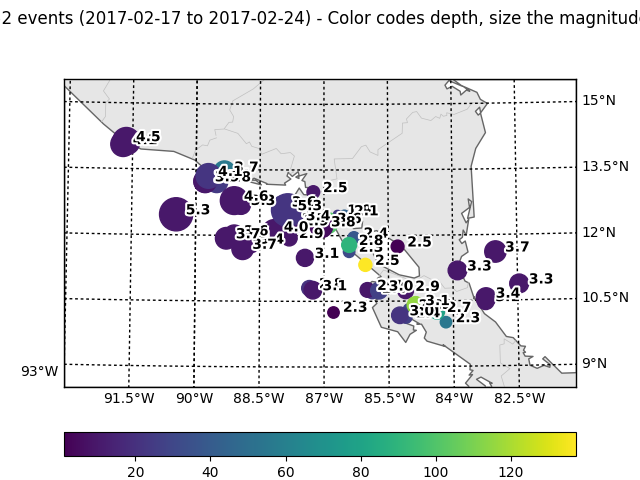

52 Event(s) in Catalog:
2017-02-23T11:27:25.983038Z | +12.480,  -86.682 | 1.894949771 M  | automatic
2017-02-18T11:47:02.312021Z | +12.465,  -86.523 | 2.139119739 M  | automatic
...
2017-02-24T13:41:13.749506Z | +12.583,  -87.846 | 5.257820586 M  | automatic
2017-02-17T23:35:16.282402Z | +12.468,  -90.459 | 5.316994555 M  | automatic
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [127]:
eewcat = client_eew.get_events(starttime=start,endtime=end,
                      minlatitude=lat[0],maxlatitude=lat[1],minlongitude=lon[0],maxlongitude=lon[1],
                      orderby='magnitude-asc',includearrivals=True,includeallorigins=True,includeallmagnitudes=True)
fig = eewcat.plot(projection='local')
print(eewcat)

## Misfits 

### How consistent are EEW and main systems ?

In [103]:
missed_main = obspy.core.event.Catalog()
missed_eew = obspy.core.event.Catalog()
falses_eew = obspy.core.event.Catalog()
#falses_main = obspy.core.event.Catalog()
eewcat_checked = obspy.core.event.Catalog()

for e in eewcat.events:
    o = e.preferred_origin() or e.origins[-1]
    found=False 
    real=False
    
    for ref in cat.events: 
        refo = ref.preferred_origin() or ref.origins[-1]
        refm = ref.preferred_magnitude() or ref.magnitudes[-1] 
        if abs(o.time-refo.time) < 60: # These 2 match
            found=True  
            foundo = refo.copy()
            foundm = refm.copy()
            if refo.evaluation_mode != 'automatic' and refm.evaluation_mode != 'automatic' : # the ref eq is real
                real = True 
            if ref.event_type == 'earthquake':     # the ref eq is real
                real = True
            if e.event_type == 'earthquake':       # the eew eq is real
                real = True
    if not found:
        if not real: # misfit & fake
            falses_eew.append(e)
        else:        # misfit but real eq
            missed_main.append(e)
    else:
        if not real: # match & fake
            falses_eew.append(e)
        else:        # match & real eq (eew origins + ref origin)
            eewcat_checked.events.append(e)
            eewcat_checked.events[-1].origins.append(foundo)
            eewcat_checked.events[-1].magnitudes.append(foundm)            

### False alarms
Not identified as earthquakes.

<IPython.core.display.Javascript object>


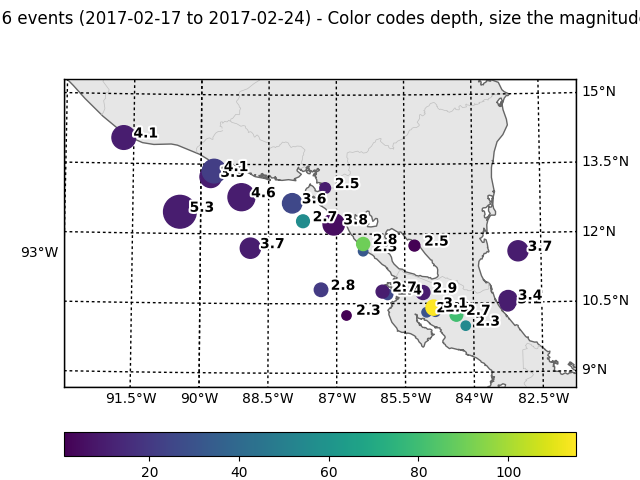

26 Event(s) in Catalog:
2017-02-18T11:07:39.885286Z | +10.009,  -84.174 | 2.27811192 M  | automatic
2017-02-18T12:06:52.732681Z | +10.263,  -86.786 | 2.284773493 M  | manual
...
2017-02-23T19:29:30.944941Z | +12.794,  -89.102 | 4.567481298 M  | automatic
2017-02-17T23:35:16.282402Z | +12.468,  -90.459 | 5.316994555 M  | automatic
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [20]:
if len(falses_eew)>0:
    falses_eew.plot(projection='local',resolution='i')
print(falses_eew)

###  Review of false alarms
To do

### Extra EEW missing in EAL

In [21]:
if len(missed_main)>0:
    missed_main.plot(projection='local',resolution='i')
print(missed_main)

0 Event(s) in Catalog:



###  Review of extra EEW
To do

## How consistent is INETER EEW catalog
### How consistent and how fast are 1rst Mvs ?

<IPython.core.display.Javascript object>


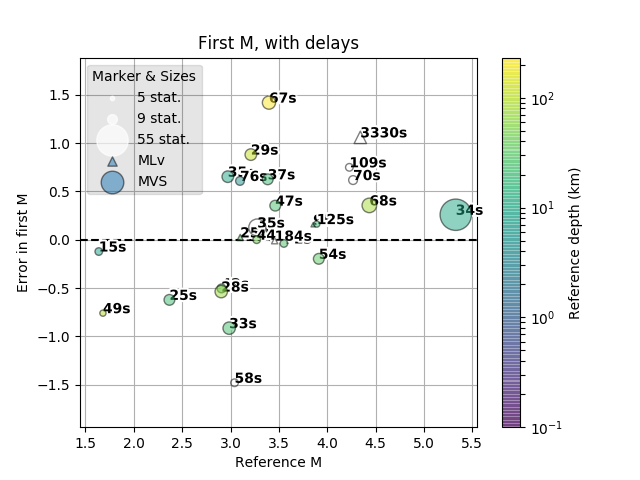

26 Event(s) in Catalog:
2017-02-23T11:27:25.983038Z | +12.480,  -86.682 | 1.894949771 M  | automatic
2017-02-18T11:47:02.312021Z | +12.465,  -86.523 | 2.139119739 M  | automatic
...
2017-02-18T23:31:22.642209Z | +14.123,  -91.650 | 4.503060606 M  | automatic
2017-02-24T13:41:13.749506Z | +12.583,  -87.846 | 5.257820586 M  | automatic
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [35]:
mags =          [e.magnitudes[-1].mag                        for e in eewcat_checked.events ]
profs =         [e.origins[-1].depth/1000.                   for e in eewcat_checked.events ]
mags_stations = [e.magnitudes[-1].station_count              for e in eewcat_checked.events ]
m1_errors =     [e.magnitudes[-1].mag-e.magnitudes[0].mag    for e in eewcat_checked.events ]
m1_types =      [e.magnitudes[0].magnitude_type              for e in eewcat_checked.events ]
m1_times =      [e.magnitudes[0].creation_info.creation_time for e in eewcat_checked.events ]
m1_origint =    [e.origins[-1].time                          for e in eewcat_checked.events ]
m1_delays = numpy.asarray(m1_times)-numpy.asarray(m1_origint)

f, (ax) = matplotlib.pyplot.subplots(1, 1)
matplotlib.pyplot.ylabel('Error in first M')
matplotlib.pyplot.xlabel('Reference M')
matplotlib.pyplot.title('First M, with delays')
matplotlib.pyplot.grid()

for m in [min(mags_stations),numpy.median(mags_stations),max(mags_stations)]:
    sc = ax.scatter(numpy.mean(mags), 0, 
                    (m-min(mags_stations)+1)/(max(mags_stations)-min(mags_stations))*500, 
                    'w', 'o', label=str(int(m))+' stat.',alpha=0.7 )

ax.axhline(0, linestyle='--', color='k') # horizontal lines

if len(m1_delays)<64:
    for i, txt in enumerate(m1_delays):
        ax.text(mags[i], m1_errors[i], str(int(txt))+'s', weight="heavy",
                color="k", zorder=100,
                path_effects=[
                    matplotlib.patheffects.withStroke(linewidth=3,
                                           foreground="white")])
types = ['M*','MLv','MVS']
for i,m in enumerate(['+','^','o']):
    matches = [ j for j,t in enumerate(m1_types) if t == types[i] ]
    if matches:
        sc = ax.scatter([mags[j] for j in matches] , 
                        [m1_errors[j] for j in matches] , 
                        [(mags_stations[j]-min(mags_stations)+1)/(max(mags_stations)-min(mags_stations))*500 for j in matches] ,
                        [profs[j] for j in matches], 
                        m, 
                        norm=matplotlib.colors.LogNorm(vmin=0.1, vmax=numpy.max(profs)),
                        label=types[i],alpha=0.5,zorder=150,edgecolors='k')
cb=matplotlib.pyplot.colorbar(sc)
cb.set_label('Reference depth (km)')
lg = matplotlib.pyplot.legend()
lg.set_title('Marker & Sizes')
lg.get_frame().set_alpha(0.1)
lg.get_frame().set_color('k')
matplotlib.pyplot.axis('equal')
print(eewcat_checked)

###  Review of erroneous EEM cases
To do

## How performant are the EEW ?

<IPython.core.display.Javascript object>


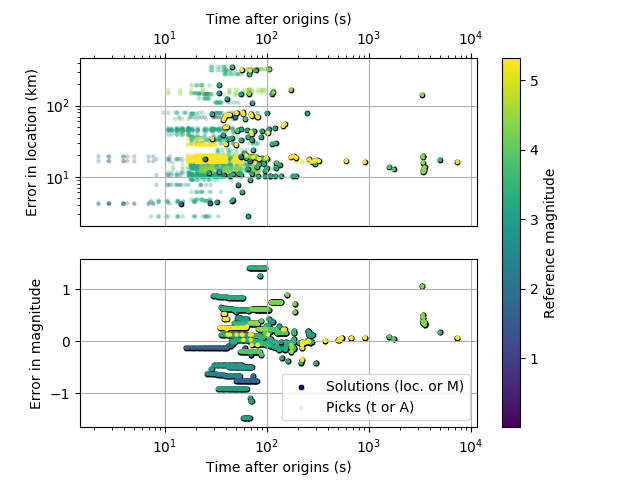

In [147]:
f, (ax1,ax2) = matplotlib.pyplot.subplots(2, 1, sharex=True)
ax1.set_ylabel('Error in location (km)')
ax2.set_ylabel('Error in magnitude')
ax1.set_xlabel('Time after origins (s)')
ax2.set_xlabel('Time after origins (s)')
ax2.set_xscale('log')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.xaxis.set_label_position('top') 
ax1.xaxis.set_ticks_position('top') 
ax1.grid()
ax2.grid()
        
        
dmins=[]
for e in eewcat_checked.events:
    for o in e.origins:
        if len(o.arrivals)>0:
            dmins.append(numpy.min([a.distance for a in o.arrivals]))

            
for e in eewcat_checked.events:
    
    el =  [numpy.sqrt(haversine(e.origins[-1].longitude,e.origins[-1].latitude,o.longitude,o.latitude)**2+(e.origins[-1].depth-o.depth)**2)/1000 for o in e.origins]
    dtl = [o.creation_info.creation_time-e.origins[-1].time for o in e.origins]   
    
    picks = e.picks.copy()
    for i,o in enumerate(e.origins):
        picks_creationtime = []
        picks_time = []
        picks_el = []
        plist = []
        if i<len(e.origins):
            for a in o.arrivals:                 
                if a.time_weight < 4 : #abs(a.time_residual)<(a.distance)/5./3:
                    for p in picks:
                        if a.pick_id == p.resource_id and p.time-e.origins[-1].time > .5 and p.time not in plist:
                            picks_time.append(p.time-e.origins[-1].time)
                            picks_creationtime.append(p.creation_info.creation_time-e.origins[-1].time)
                            picks_el.append(el[i])
                            picks.remove(p)
                            plist.append(p.time)
                            break

            ax1.scatter(picks_time,picks_el,10,
                        numpy.repeat(e.magnitudes[-1].mag,len(picks_el)),#marker='+',
                        norm=matplotlib.colors.PowerNorm(1,vmin=0.01, vmax=numpy.max(mags)),
                        zorder=-99,alpha=0.3, edgecolors='none')
            
        
    ax1.scatter(dtl[:-1],el[:-1],10,marker='o',edgecolors='k') 
    sc1 = ax1.scatter(dtl[:-1],el[:-1],10,
                numpy.repeat(e.magnitudes[-1].mag,len(dtl)-1),marker='o',
                norm=matplotlib.colors.PowerNorm(1,vmin=0.01, vmax=numpy.max(mags)),
                label=e.short_str(),linewidths=0,zorder=999)


    em =  [e.magnitudes[-1].mag-m.mag           for m in e.magnitudes]
    dtm = [m.creation_info.creation_time-e.origins[-1].time for m in e.magnitudes]
 
    ax2.scatter(dtm[:-1],em[:-1],10,marker='o',edgecolors='k')      
    sc2 = ax2.scatter(dtm[:-1],em[:-1],10,
                numpy.repeat(e.magnitudes[-1].mag,len(dtm)-1),marker='o',
                norm=matplotlib.colors.PowerNorm(1,vmin=0.01, vmax=numpy.max(mags)),
                label=e.short_str(),linewidths=0,zorder=999)  

cb=matplotlib.pyplot.colorbar(sc1, ax=[ax1,ax2])
cb.set_label('Reference magnitude')
ob2 = ax2.scatter(20,0,10,marker='o',alpha=0.1,color='b', edgecolors='none',zorder=-999)
ob1 = ax2.scatter(20,0,10,marker='o',color='b',edgecolors='k',zorder=-999)
ax2.scatter(20,0,10,marker='o',color='w',edgecolors='w',linewidths=3,zorder=-99)
lg = matplotlib.pyplot.legend((ob1, ob2), ('Solutions (loc. or M)', 'Picks (t or A)'))

###  Review of slow EEW cases
To do